# Understanding Hired Rides in NYC



## Project Setup

In [1]:
# All import statements needed for the project

import os
import bs4
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db
import re
import gc
from datetime import datetime, timedelta
import numpy as np
import math
import glob
import scipy
from scipy.stats import t
import seaborn as sns

In [2]:
# Contents Needed

TLC_URL = "https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "data/taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = "data/weather"

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [3]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

## Part 1: Data Preprocessing

### Load Taxi Zones

In [4]:
def load_taxi_zones(shapefile):
    """
    Load taxi zones shapefile using geopandas.

    Args:
        shapefile (str): Path to the taxi zones shapefile.

    Returns:
        GeoDataFrame: The loaded GeoDataFrame containing taxi zones data.
    """
    # Read the shapefile using geopandas
    geofile = gpd.read_file(shapefile)

    # Return the loaded GeoDataFrame
    return geofile

In [5]:
def lookup_coords_for_taxi_zone_id(zone_loc_id, loaded_taxi_zones):
    """
    Find the geographical coordinates of a taxi zone by its ID.

    Args:
        zone_loc_id (int): The ID of the taxi zone.
        loaded_taxi_zones (GeoDataFrame): GeoDataFrame containing taxi zones data.

    Returns:
        tuple or None: The latitude and longitude as a tuple, or None if not found.
    """
    # Filter the GeoDataFrame for the specified taxi zone ID
    zone = loaded_taxi_zones[loaded_taxi_zones['LocationID'] == zone_loc_id]

    # Check if the specified zone ID exists
    if zone.empty:
        return None

    # Compute the centroid of the matched zone's geometry
    centroid = zone.geometry.centroid.iloc[0]

    # Return the latitude (y) and longitude (x) as a tuple
    return (centroid.y, centroid.x)

### Calculate Sample Size

In [6]:
def calculate_sample_size(population: int, confidence_level: float = 0.95, margin_of_error: float = 0.05, p: float = 0.5) -> int:
    """
    Calculate the sample size using Cochran's formula.

    Args:
        population (int): The total number of data points in the population.
        confidence_level (float): The confidence level (default is 0.95).
        margin_of_error (float): The margin of error (default is 0.05).
        p (float): The estimated proportion of the population.

    Returns:
        int: The calculated sample size.
    """
    # Map confidence levels to their corresponding z-scores
    z = {0.90: 1.645, 0.95: 1.96, 0.99: 2.576}.get(confidence_level, 1.96)

    # Compute the initial sample size using Cochran's formula
    numerator = (z ** 2) * p * (1 - p)
    denominator = margin_of_error ** 2
    sample_size = numerator / denominator

    # Adjust sample size for finite populations
    if population > 0:
        adjusted_sample_size = sample_size / (1 + (sample_size - 1) / population)
    else:
        adjusted_sample_size = sample_size

    return int(np.ceil(adjusted_sample_size))

### Common Functions

In [7]:
def get_all_urls_from_tlc_page(taxi_page):
    """
    Fetches all URLs from a given webpage.

    Args:
        taxi_page (str): URL of the webpage to scrape.

    Returns:
        list: List of all URLs found on the webpage.
    """
    try:
        # Send a GET request to the page
        response = requests.get(taxi_page)
        response.raise_for_status()  # Raise an HTTPError for bad responses
    except requests.exceptions.RequestException as e:
        # Handle exceptions and provide an informative error message
        raise Exception(f"Failed to access the URL: {taxi_page}. Error: {e}")

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.content, "html.parser")

    # Find all anchor tags with href attributes
    links = soup.find_all("a", href=True)

    # Extract and return all href attributes
    all_urls = [link["href"] for link in links]

    return all_urls

In [8]:
def filter_parquet_urls(all_urls):
    """
    Filter and return only URLs pointing to Parquet files.

    Args:
        all_urls (list): List of all URLs to filter.

    Returns:
        list: List of URLs pointing to Parquet files.
    """
    # Initialize an empty list to store Parquet file URLs
    parquet_urls = []

    # Iterate through each URL in the input list
    for url in all_urls:
        url = url.strip()
        
        # Use regex to ensure matching even with query parameters
        if re.search(r"\.parquet(\?.*)?$", url):
            parquet_urls.append(url)

    return parquet_urls

### Process Taxi Data

In [9]:
def get_and_clean_taxi_month(url: str) -> pd.DataFrame:
    """
    Downloads, processes, and saves Yellow Taxi dataset for a given month.

    Args:
        url (str): URL of the Yellow Taxi Parquet file.

    Returns:
        pd.DataFrame: Sampled and processed DataFrame, or an empty DataFrame if the file is invalid.
    """
    save_dir = "processed_data/yellow_taxi"
    os.makedirs(save_dir, exist_ok=True)  # Ensure the save directory exists

    file_name = url.split("/")[-1]
    local_file_path = os.path.join(save_dir, file_name)

    # Step 1: Download the file if it doesn't exist
    if not os.path.exists(local_file_path):
        print(f"Downloading file: {url}")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(local_file_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024 * 1024):  # 1MB chunks
                    if chunk:
                        f.write(chunk)
            print(f"Downloaded and saved file: {local_file_path}")
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {url}: {e}")
            return pd.DataFrame()

    # Step 2: Load the Parquet file
    try:
        data = pd.read_parquet(local_file_path)
        if data.empty or not data.notna().any().any():
            print(f"File {local_file_path} is empty or contains only NaN values.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error reading Parquet file {local_file_path}: {e}")
        return pd.DataFrame()

    # Step 3: Sample the dataset
    population = len(data)
    if population == 0:
        print(f"File {local_file_path} contains no data.")
        return pd.DataFrame()
    sample_size = calculate_sample_size(population, p=0.5)
    sampled_data = data.sample(n=sample_size, random_state=42) if population > sample_size else data

    # Step 4: Save the processed data
    processed_file_path = os.path.join(save_dir, f"sampled_{file_name}")
    sampled_data.to_parquet(processed_file_path)
    print(f"Processed data saved to: {processed_file_path}")

    return sampled_data

In [10]:
def get_and_clean_taxi_data(parquet_urls):
    """
    Process multiple Parquet files of taxi data by filtering, cleaning, and combining them into a single DataFrame.

    Args:
        parquet_urls (list): List of Parquet file URLs to process.

    Returns:
        pd.DataFrame: Combined DataFrame containing all cleaned taxi data.
    """
    all_taxi_dataframes = []  # Initialize a list to store cleaned DataFrames

    # Step 1: Filter URLs using regex
    yellow_taxi_pattern = re.compile(r"yellow_tripdata_(202[0-4]-(0[1-9]|1[0-2]))\.parquet")
    yellow_taxi_urls = [url for url in parquet_urls if yellow_taxi_pattern.search(url)]
    if not yellow_taxi_urls:
        print("No URLs matched the Yellow Taxi data pattern.")
        return pd.DataFrame()

    print(f"Processing {len(yellow_taxi_urls)} files matching the pattern.")

    # Step 2: Process each filtered URL
    for url in yellow_taxi_urls:
        dataframe = get_and_clean_taxi_month(url)
        if not dataframe.empty:
            if "Airport_fee" in dataframe.columns:
                dataframe = dataframe.rename(columns={"Airport_fee": "airport_fee"})  # Avoid inplace=True

            # Inline logic to clean numeric and datetime columns
            for col in dataframe.columns:
                if pd.api.types.is_numeric_dtype(dataframe[col]):
                    dataframe[col] = dataframe[col].fillna(0)  # Avoid inplace=True
                elif pd.api.types.is_datetime64_any_dtype(dataframe[col]) and dataframe[col].isna().all():
                    dataframe = dataframe.drop(columns=[col])  # Avoid inplace=True

            all_taxi_dataframes.append(dataframe)

    # Step 3: Handle column inconsistencies and NaN issues
    if all_taxi_dataframes:
        # Remove all-NaN columns
        all_taxi_dataframes = [df.dropna(how='all', axis=1) for df in all_taxi_dataframes]

        # Ensure common columns across all DataFrames
        common_columns = list(set.intersection(*[set(df.columns) for df in all_taxi_dataframes]))  # Convert set to list
        all_taxi_dataframes = [df[common_columns] for df in all_taxi_dataframes]

        # Concatenate all cleaned DataFrames
        taxi_data = pd.concat(all_taxi_dataframes, ignore_index=True)
        print(f"Successfully combined {len(all_taxi_dataframes)} DataFrames.")
    else:
        print("No valid DataFrames to combine.")
        taxi_data = pd.DataFrame()

    return taxi_data

In [11]:
def get_taxi_data():
    """
    Main function to fetch, process, and clean all taxi data from a predefined URL.

    Returns:
        pd.DataFrame: Combined and cleaned taxi data.
    """
    # Fetch all URLs from the TLC page
    all_urls = get_all_urls_from_tlc_page(TLC_URL)

    # Filter the URLs to get only those pointing to Parquet files
    all_parquet_urls = filter_parquet_urls(all_urls)

    # Process the filtered Parquet files and combine them
    taxi_data = get_and_clean_taxi_data(all_parquet_urls)

    return taxi_data

In [12]:
# Fetch and process all taxi data
taxi_data = get_taxi_data()

Processing 57 files matching the pattern.
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-01.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-02.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-03.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-04.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-05.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-06.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-07.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-08.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2024-09.parquet
Processed data saved to: processed_data/yellow_taxi/sampled_yellow_tripdata_2023-01.parquet
Processed data saved to: processed_dat

In [13]:
taxi_data.head()

,total_amount,VendorID,fare_amount,improvement_surcharge,RatecodeID,passenger_count,PULocationID,mta_tax,store_and_fwd_flag,tolls_amount,congestion_surcharge,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,payment_type,DOLocationID,tip_amount,extra
0,90.96,2,70.0,1.0,2.0,2.0,132,0.5,N,6.94,2.5,2024-01-20 13:31:30,2024-01-20 14:03:25,17.14,1,233,8.27,0.0
1,22.50,2,13.5,1.0,1.0,1.0,163,0.5,N,0.00,2.5,2024-01-18 21:52:46,2024-01-18 22:03:21,2.49,1,75,4.00,1.0
2,12.50,2,10.0,1.0,1.0,2.0,127,0.5,N,0.00,0.0,2024-01-01 03:43:58,2024-01-01 03:50:47,1.84,2,20,0.00,1.0
3,33.95,1,23.3,1.0,1.0,1.0,186,0.5,N,0.00,2.5,2024-01-19 22:20:12,2024-01-19 22:50:12,3.60,1,263,5.65,3.5
4,6.20,2,3.7,1.0,1.0,1.0,238,0.5,N,0.00,0.0,2024-01-06 22:41:50,2024-01-06 22:43:24,0.04,2,238,0.00,1.0


In [14]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21941 entries, 0 to 21940
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   total_amount           21941 non-null  float64       
 1   VendorID               21941 non-null  int64         
 2   fare_amount            21941 non-null  float64       
 3   improvement_surcharge  21941 non-null  float64       
 4   RatecodeID             21941 non-null  float64       
 5   passenger_count        21941 non-null  float64       
 6   PULocationID           21941 non-null  int64         
 7   mta_tax                21941 non-null  float64       
 8   store_and_fwd_flag     20730 non-null  object        
 9   tolls_amount           21941 non-null  float64       
 10  congestion_surcharge   21941 non-null  float64       
 11  tpep_pickup_datetime   21941 non-null  datetime64[us]
 12  tpep_dropoff_datetime  21941 non-null  datetime64[us]
 13  t

In [15]:
taxi_data.describe()

,total_amount,VendorID,fare_amount,improvement_surcharge,RatecodeID,passenger_count,PULocationID,mta_tax,tolls_amount,congestion_surcharge,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,payment_type,DOLocationID,tip_amount,extra
count,21941.000000,21941.000000,21941.000000,21941.000000,21941.000000,21941.000000,21941.000000,21941.000000,21941.000000,21941.000000,21941,21941,21941.000000,21941.000000,21941.000000,21941.000000,21941.000000
mean,22.713167,1.719429,15.659498,0.550052,1.398888,1.321407,165.091199,0.488059,0.453536,2.141083,2022-05-17 00:57:00.007338,2022-05-17 01:13:18.223371,3.292919,1.182854,161.639898,2.704115,1.196216
min,-251.000000,1.000000,-250.000000,-1.000000,0.000000,0.000000,4.000000,-0.500000,-34.200000,-2.500000,2009-01-01 01:11:17,2009-01-01 01:11:20,0.000000,0.000000,1.000000,-0.130000,-7.500000
25%,12.770000,1.000000,7.200000,0.300000,1.000000,1.000000,132.000000,0.500000,0.000000,2.500000,2021-03-10 07:21:05,2021-03-10 07:26:47,1.050000,1.000000,107.000000,0.000000,0.000000
50%,17.150000,2.000000,11.000000,0.300000,1.000000,1.000000,162.000000,0.500000,0.000000,2.500000,2022-05-16 18:05:44,2022-05-16 18:18:08,1.800000,1.000000,162.000000,2.150000,0.500000
75%,24.840000,2.000000,17.700000,1.000000,1.000000,1.000000,234.000000,0.500000,0.000000,2.500000,2023-07-25 16:04:59,2023-07-25 16:18:31,3.310000,1.000000,234.000000,3.450000,2.500000
max,289.350000,6.000000,278.800000,1.000000,99.000000,6.000000,265.000000,0.500000,57.050000,2.500000,2024-09-30 23:52:50,2024-09-30 23:56:08,67.900000,4.000000,265.000000,51.150000,11.750000
std,19.218796,0.492829,15.476094,0.355888,6.209745,1.003036,65.707289,0.098153,1.913663,0.918538,NaN,NaN,4.276046,0.569043,70.845724,3.294636,1.515058


### Processing Uber Data

In [16]:
def get_and_clean_uber_month(url):
    save_dir = "processed_data/hvhf"

    # Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # Extract file name and define local path
    file_name = url.split("/")[-1]
    local_file_path = os.path.join(save_dir, file_name)

    # Download the file if not already downloaded
    if not os.path.exists(local_file_path):
        print(f"Downloading HVHF file: {url} ...")
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(local_file_path, "wb") as f:
                for chunk in response.iter_content(chunk_size=1024 * 1024):  # 1MB chunks
                    if chunk:
                        f.write(chunk)
            print(f"File saved to: {local_file_path}")
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {url}: {e}")
            return pd.DataFrame()  # Return an empty DataFrame if download fails
    else:
        print(f"Loading file from local storage: {local_file_path}")

    # Load the dataset
    try:
        data = pd.read_parquet(local_file_path)
    except Exception as e:
        print(f"Error reading Parquet file {local_file_path}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame if reading fails

    # Determine population size
    population = len(data)
    print(f"Population size: {population}")

    # Calculate sample size (using p = 0.5 for Yellow Taxi data)
    sample_size = calculate_sample_size(population, p = 0.4)
    print(f"Calculated sample size: {sample_size}")

    # Sample the dataset
    sampled_data = data.sample(n=sample_size, random_state=42) if population > sample_size else data

    # Save the sampled dataset
    processed_file_path = os.path.join(save_dir, f"sampled_{file_name}")
    sampled_data.to_parquet(processed_file_path)
    print(f"Processed file saved to: {processed_file_path}")

    return sampled_data

In [17]:
def get_and_clean_uber_data(parquet_urls):
    """
    Process multiple Parquet files of Uber data by filtering, cleaning, and combining them into a single DataFrame.

    Args:
        parquet_urls (list): List of Parquet file URLs to process.

    Returns:
        pd.DataFrame: Combined DataFrame containing all cleaned Uber data.
    """
    all_uber_dataframes = []

    # Filter URLs of HVHF data
    hvfhv_pattern = re.compile(r"fhvhv_tripdata_(2020-(0[1-9]|1[0-2])|2021-(0[1-9]|1[0-2])|2022-(0[1-9]|1[0-2])|2023-(0[1-9]|1[0-2])|2024-(0[1-9]))\.parquet")
    hvfhv_urls = [url for url in parquet_urls if hvfhv_pattern.search(url)]

    for url in hvfhv_urls:
        # Clean data through function defined before
        dataframe = get_and_clean_uber_month(url)

        # Skip empty dataframes and dealing with NaN
        if not dataframe.empty:
            dataframe = dataframe.dropna(axis=1, how='all')
            all_uber_dataframes.append(dataframe)

    # Combine all non-empty HVHF data
    uber_data = pd.concat(all_uber_dataframes, ignore_index=True)
    return uber_data

In [18]:
def load_and_clean_uber_data(uber_data: pd.DataFrame) -> pd.DataFrame:
    """
    Clean and process Uber HVHF data, including filtering by license, adding coordinates,
    retaining required columns, and normalizing data.

    Args:
        uber_data (pd.DataFrame): A DataFrame containing combined HVHF data.

    Returns:
        pd.DataFrame: A cleaned and filtered DataFrame with necessary columns and normalized values.
    """
    uber_data['hvfhs_license_num'] = uber_data['hvfhs_license_num'].astype(str)

    # Filter rows where 'hvfhs_license_num' is 'HV0003' (Uber)
    uber_only_data = uber_data[uber_data['hvfhs_license_num'] == 'HV0003'].copy()
    return uber_only_data

In [19]:
def get_uber_data() -> pd.DataFrame:
    """
    Retrieve, filter, process, and clean Uber HVHF data from the TLC data page.

    Returns:
        pd.DataFrame: A cleaned and processed DataFrame containing Uber HVHF trip data.
    """
    all_urls = get_all_urls_from_tlc_page(TLC_URL)
    all_parquet_urls = filter_parquet_urls(all_urls)
    u_data = get_and_clean_uber_data(all_parquet_urls)
    uber_data = load_and_clean_uber_data(u_data)
    return uber_data

In [20]:
uber_data = get_uber_data()

Loading file from local storage: processed_data/hvhf/fhvhv_tripdata_2024-01.parquet
Population size: 19663930
Calculated sample size: 369
Processed file saved to: processed_data/hvhf/sampled_fhvhv_tripdata_2024-01.parquet
Loading file from local storage: processed_data/hvhf/fhvhv_tripdata_2024-02.parquet
Population size: 19359148
Calculated sample size: 369
Processed file saved to: processed_data/hvhf/sampled_fhvhv_tripdata_2024-02.parquet
Loading file from local storage: processed_data/hvhf/fhvhv_tripdata_2024-03.parquet
Population size: 21280788
Calculated sample size: 369
Processed file saved to: processed_data/hvhf/sampled_fhvhv_tripdata_2024-03.parquet
Loading file from local storage: processed_data/hvhf/fhvhv_tripdata_2024-04.parquet
Population size: 19733038
Calculated sample size: 369
Processed file saved to: processed_data/hvhf/sampled_fhvhv_tripdata_2024-04.parquet
Loading file from local storage: processed_data/hvhf/fhvhv_tripdata_2024-05.parquet
Population size: 20704538
Ca

In [21]:
uber_data.head()

,hvfhs_license_num,dispatching_base_num,originating_base_num,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
1,HV0003,B03404,B03404,2024-01-26 07:58:05,2024-01-26 08:06:17,2024-01-26 08:07:17,2024-01-26 08:35:38,85,77,4.29,...,2.44,0.00,0.0,0.00,24.88,N,N,N,N,N
2,HV0003,B03404,B03404,2024-01-19 02:12:56,2024-01-19 02:16:27,2024-01-19 02:17:05,2024-01-19 02:29:12,220,243,2.55,...,1.34,0.00,0.0,0.00,10.19,N,N,N,N,N
3,HV0003,B03404,B03404,2024-01-21 01:39:37,2024-01-21 01:43:40,2024-01-21 01:44:00,2024-01-21 02:08:30,164,80,6.37,...,2.18,2.75,0.0,3.01,23.00,N,N,N,N,N
5,HV0003,B03404,B03404,2024-01-20 12:56:18,2024-01-20 12:58:28,2024-01-20 12:58:40,2024-01-20 13:15:42,161,246,1.99,...,1.68,2.75,0.0,0.00,12.47,N,N,N,N,N
8,HV0003,B03404,B03404,2024-01-02 08:22:37,2024-01-02 08:40:29,2024-01-02 08:40:48,2024-01-02 08:54:28,77,177,2.23,...,1.43,0.00,0.0,0.00,10.64,N,N,N,N,N


In [22]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15007 entries, 1 to 20663
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   hvfhs_license_num     15007 non-null  object        
 1   dispatching_base_num  15007 non-null  object        
 2   originating_base_num  15004 non-null  object        
 3   request_datetime      15007 non-null  datetime64[us]
 4   on_scene_datetime     15007 non-null  datetime64[us]
 5   pickup_datetime       15007 non-null  datetime64[us]
 6   dropoff_datetime      15007 non-null  datetime64[us]
 7   PULocationID          15007 non-null  int64         
 8   DOLocationID          15007 non-null  int64         
 9   trip_miles            15007 non-null  float64       
 10  trip_time             15007 non-null  int64         
 11  base_passenger_fare   15007 non-null  float64       
 12  tolls                 15007 non-null  float64       
 13  bcf                  

In [23]:
uber_data.describe()

,request_datetime,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,base_passenger_fare,tolls,bcf,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay
count,15007,15007,15007,15007,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000,15007.000000,11322.000000,15007.000000,15007.000000
mean,2022-05-30 01:05:51.999067,2022-05-30 01:09:28.801959,2022-05-30 01:10:36.636902,2022-05-30 01:29:10.957886,138.075165,141.315919,4.861705,1114.570467,22.736776,1.051331,0.673654,1.911541,1.026454,0.189785,0.920415,18.175383
min,2020-01-01 02:45:20,2020-01-01 02:48:30,2020-01-01 02:50:21,2020-01-01 03:12:01,3.000000,1.000000,0.000000,47.000000,-24.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021-04-05 20:15:09,2021-04-05 20:18:02.500000,2021-04-05 20:19:31,2021-04-05 20:26:42.500000,74.000000,74.000000,1.585000,570.500000,10.690000,0.000000,0.300000,0.890000,0.000000,0.000000,0.000000,8.550000
50%,2022-06-05 21:12:58,2022-06-05 21:16:39,2022-06-05 21:18:24,2022-06-05 21:37:52,140.000000,141.000000,2.940000,908.000000,17.220000,0.000000,0.490000,1.460000,0.000000,0.000000,0.000000,13.860000
75%,2023-08-05 07:12:40,2023-08-05 07:17:32.500000,2023-08-05 07:18:25.500000,2023-08-05 07:46:14.500000,211.000000,216.000000,6.000000,1428.000000,27.760000,0.000000,0.820000,2.400000,2.750000,0.000000,0.000000,22.650000
max,2024-09-30 21:32:29,2024-09-30 21:35:32,2024-09-30 21:35:40,2024-09-30 21:50:59,263.000000,265.000000,123.170000,9710.000000,347.900000,43.890000,10.440000,30.880000,2.750000,5.000000,58.790000,261.440000
std,NaN,NaN,NaN,NaN,75.456983,78.021371,5.683653,786.861853,19.606982,3.826854,0.629085,1.613499,1.325656,0.665196,2.940724,14.922692


### Processing Weather Data

In [24]:
def get_all_weather_csvs(directory):
    """
    Reads all CSV files from the specified directory.

    Args:
        directory (str): The directory path containing the weather data CSV files.

    Returns:
        list: A list of pandas DataFrames, each corresponding to a CSV file.
    """
    files = glob.glob(os.path.join(directory, '*.csv'))

    csv_files = []
    for file in files:
        # Read each CSV file and append it to the list
        df = pd.read_csv(file, low_memory=False)
        csv_files.append(df)
    return csv_files

In [25]:
def clean_hourly_weather_data(csv_file):
    # create the dataframe with columns needed for hourly data
    columns = ["DATE", "HourlyPrecipitation", "HourlyWindSpeed"]
    hourly_data = csv_file[columns].copy()

    # Convert DATE columns to datetime type
    hourly_data["DATE"] = pd.to_datetime(hourly_data["DATE"], errors="coerce")

    # filter out non-hourly rows in the dataframe
    hourly_data = hourly_data[hourly_data["DATE"].dt.strftime("%H:%M:%S") != "23:59:00"]

    # Clean up HourlyPrecipitation columns
    hourly_data["HourlyPrecipitation"] = hourly_data["HourlyPrecipitation"].replace("T", 0.01)  # replace trace amount by 0.01
    hourly_data["HourlyPrecipitation"] = pd.to_numeric(hourly_data["HourlyPrecipitation"], errors="coerce").fillna(0)  # replace NaN by 0

    # Clean up HourlyWindSpeed ​​columns
    hourly_data["HourlyWindSpeed"] = pd.to_numeric(hourly_data["HourlyWindSpeed"], errors="coerce").fillna(0)

    return hourly_data

In [26]:
def clean_daily_weather_data(csv_file):
    """
    Cleans and extracts necessary columns for daily weather data.

    Args:
        csv_file (DataFrame): A pandas DataFrame containing raw weather data.

    Returns:
        DataFrame: A cleaned DataFrame containing only required daily weather data.
    """
    # create the dataframe with columns needed for daily data
    columns = ["DATE", "DailyPrecipitation", "DailyAverageWindSpeed", "DailySnowfall", "Sunrise", "Sunset"]
    daily_data = csv_file[columns].copy()

    # Convert DATE columns to datetime type
    daily_data["DATE"] = pd.to_datetime(daily_data["DATE"], errors="coerce")

    # filter out non-daily rows in the dataframe
    daily_data = daily_data[daily_data["DATE"].dt.strftime("%H:%M:%S") == "23:59:00"]

    # Clean up DailyPrecipitation columns
    daily_data["DailyPrecipitation"] = daily_data["DailyPrecipitation"].replace("T", 0.01) # replace trace amount by 0.01
    daily_data["DailyPrecipitation"] = pd.to_numeric(daily_data["DailyPrecipitation"], errors="coerce").fillna(0) # replace NaN by 0

    # Clean up DailySnowfall columns
    daily_data["DailySnowfall"] = daily_data["DailySnowfall"].replace("T", 0.01)  
    daily_data["DailySnowfall"] = pd.to_numeric(daily_data["DailySnowfall"], errors="coerce").fillna(0)

    # Clean up DailyAverageWindSpeed ​​columns
    daily_data["DailyAverageWindSpeed"] = pd.to_numeric(daily_data["DailyAverageWindSpeed"], errors="coerce").fillna(0)

    # Clean Sunrise and Sunset columns
    daily_data["Sunrise"] = pd.to_datetime(
        (daily_data["Sunrise"].astype(str).str.zfill(4).str[:2] + ":" +
         daily_data["Sunrise"].astype(str).str.zfill(4).str[2:]),
        format="%H:%M", errors="coerce"
    ).dt.strftime("%H:%M")

    daily_data["Sunset"] = pd.to_datetime(
        (daily_data["Sunset"].astype(str).str.zfill(4).str[:2] + ":" +
         daily_data["Sunset"].astype(str).str.zfill(4).str[2:]),
        format="%H:%M", errors="coerce"
    ).dt.strftime("%H:%M")

    return daily_data

In [27]:
def load_and_clean_weather_data():
    """
    Loads and cleans weather data for both hourly and daily observations.

    Returns:
        tuple: Two pandas DataFrames containing cleaned hourly and daily weather data.
    """
    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)

    hourly_dataframes = []
    daily_dataframes = []

    for csv_file in weather_csv_files:
        # Clean and extract relevant data
        hourly_dataframe = clean_hourly_weather_data(csv_file)
        daily_dataframe = clean_daily_weather_data(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)

    # Combine data into single DataFrames
    hourly_data = pd.concat(hourly_dataframes, ignore_index=True)
    daily_data = pd.concat(daily_dataframes, ignore_index=True)

    return hourly_data, daily_data

In [28]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [29]:
hourly_weather_data.head()

,DATE,HourlyPrecipitation,HourlyWindSpeed
0,2020-01-01 00:51:00,0.0,8.0
1,2020-01-01 01:51:00,0.0,8.0
2,2020-01-01 02:51:00,0.0,14.0
3,2020-01-01 03:51:00,0.0,11.0
4,2020-01-01 04:51:00,0.0,6.0


In [30]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54277 entries, 0 to 54276
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE                 54277 non-null  datetime64[ns]
 1   HourlyPrecipitation  54277 non-null  float64       
 2   HourlyWindSpeed      54277 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.2 MB


In [31]:
hourly_weather_data.describe()

,DATE,HourlyPrecipitation,HourlyWindSpeed
count,54277,54277.000000,54277.000000
mean,2022-05-29 23:14:57.303830016,0.011309,4.688726
min,2020-01-01 00:51:00,0.000000,0.000000
25%,2021-03-18 21:19:00,0.000000,0.000000
50%,2022-05-28 01:51:00,0.000000,5.000000
75%,2023-08-15 07:51:00,0.000000,7.000000
max,2024-10-22 18:51:00,3.470000,2237.000000
std,NaN,0.056855,14.088974


In [32]:
daily_weather_data.head()

,DATE,DailyPrecipitation,DailyAverageWindSpeed,DailySnowfall,Sunrise,Sunset
0,2020-01-01 23:59:00,0.00,8.6,0.0,NaN,NaN
1,2020-01-02 23:59:00,0.00,5.4,0.0,NaN,NaN
2,2020-01-03 23:59:00,0.15,3.4,0.0,NaN,NaN
3,2020-01-04 23:59:00,0.27,4.4,0.0,NaN,NaN
4,2020-01-05 23:59:00,0.01,11.3,0.0,NaN,NaN


In [33]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DATE                   1821 non-null   datetime64[ns]
 1   DailyPrecipitation     1821 non-null   float64       
 2   DailyAverageWindSpeed  1821 non-null   float64       
 3   DailySnowfall          1821 non-null   float64       
 4   Sunrise                0 non-null      object        
 5   Sunset                 0 non-null      object        
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 85.5+ KB


In [34]:
daily_weather_data.describe()

,DATE,DailyPrecipitation,DailyAverageWindSpeed,DailySnowfall
count,1821,1821.000000,1821.000000,1821.000000
mean,2022-05-27 09:18:52.092256768,0.137858,4.660242,0.038001
min,2020-01-01 23:59:00,0.000000,0.000000,0.000000
25%,2021-03-13 23:59:00,0.000000,2.900000,0.000000
50%,2022-05-27 23:59:00,0.000000,4.400000,0.000000
75%,2023-08-07 23:59:00,0.050000,6.200000,0.000000
max,2024-10-21 23:59:00,7.130000,14.200000,14.800000
std,NaN,0.407515,2.585943,0.484460


## Part 2: Storing Cleaned Data

In [35]:
engine = db.create_engine(DATABASE_URL)

In [36]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    date_time TEXT PRIMARY KEY,
    temperature FLOAT,
    precipitation FLOAT,
    wind_speed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    date TEXT PRIMARY KEY,
    avg_temperature FLOAT,
    total_precipitation FLOAT,
    total_snowfall FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
    trip_id INTEGER PRIMARY KEY,
    pickup_datetime TEXT,
    dropoff_datetime TEXT,
    trip_distance FLOAT,
    fare_amount FLOAT,
    tip_amount FLOAT,
    total_amount FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
    trip_id INTEGER PRIMARY KEY,
    pickup_datetime TEXT,
    dropoff_datetime TEXT,
FLOAT    trip_distance FLOAT,
    fare_amount FLOAT,
    tip_amount FLOAT,
    total_amount FLOAT
);
"""

In [37]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [38]:
# create the tables with the schema files
with engine.connect() as connection:
    pass

In [39]:
def write_dataframes_to_table(table_to_df_dict):
    with engine.connect() as connection:
        for table_name, dataframe in table_to_df_dict.items():
            try:
                dataframe.to_sql(table_name, con=connection, if_exists="replace", index=False)
                print(f"Data written to table: {table_name}")
            except Exception as e:
                print(f"Failed to write to table {table_name}: {e}")

In [40]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [41]:
write_dataframes_to_table(map_table_name_to_dataframe)

Data written to table: taxi_trips
Data written to table: uber_trips
Data written to table: hourly_weather
Data written to table: daily_weather


## Part 3: Understanding the Data

In [42]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    filepath = os.path.join(QUERY_DIRECTORY, outfile)
    with open(filepath, "w") as f:
        f.write(query)
    print(f"Query written to file: {filepath}")

### Query 1

In [43]:
QUERY_1_FILENAME = "Query 1: Popular taxi hour.sql"

QUERY_1 = """
SELECT strftime('%H', tpep_pickup_datetime) AS hour,
       COUNT(*) AS ride_count
FROM taxi_trips
WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY hour
ORDER BY ride_count DESC;
"""

In [44]:
# execute query either via pandas
df_query_1 = pd.read_sql(QUERY_1, con=engine)
print(df_query_1.head())

  hour  ride_count
0   18        1560
1   17        1497
2   15        1457
3   16        1410
4   14        1395


In [45]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

Query written to file: queries/Query 1: Popular taxi hour.sql


### Query 2

In [46]:
QUERY_2_FILENAME = "Query 2: Popular uber day.sql"

QUERY_2 = """
SELECT strftime('%w', pickup_datetime) AS weekday,
       COUNT(*) AS ride_count
FROM uber_trips
WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY weekday
ORDER BY ride_count DESC;
"""

In [47]:
# execute query either via sqlalchemy
df_query_2 = pd.read_sql(QUERY_2, con=engine)
print(df_query_2.head())

  weekday  ride_count
0       6        2485
1       5        2355
2       4        2126
3       0        2020
4       3        2014


In [48]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

Query written to file: queries/Query 2: Popular uber day.sql


### Query 3

In [49]:
QUERY_3_FILENAME = "Query 3: Trip distance.sql"

QUERY_3 = """
WITH combined_trips AS (
    SELECT trip_distance
    FROM taxi_trips
    WHERE tpep_pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
    UNION ALL
    SELECT trip_miles AS trip_distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
),
sorted_trips AS (
    SELECT trip_distance
    FROM combined_trips
    ORDER BY trip_distance
),
percentile_index AS (
    SELECT CAST(COUNT(*) * 0.95 AS INTEGER) AS idx
    FROM sorted_trips
)
SELECT trip_distance AS percentile_95
FROM sorted_trips
LIMIT 1 OFFSET (SELECT idx - 1 FROM percentile_index);
"""

In [50]:
# execute query either via sqlalchemy
df_query_3 = pd.read_sql(QUERY_3, con=engine)
print(df_query_3.head())

   percentile_95
0           16.1


In [51]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

Query written to file: queries/Query 3: Trip distance.sql


### Query 4

In [52]:
QUERY_4_FILENAME = "Query 4: Busiest days weather.sql"

QUERY_4 = """
WITH daily_rides AS (
    SELECT strftime('%Y-%m-%d', pickup_datetime) AS ride_date,
           COUNT(*) AS total_rides,
           AVG(trip_distance) AS avg_distance
    FROM (
        SELECT tpep_pickup_datetime AS pickup_datetime, trip_distance
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
        UNION ALL
        SELECT pickup_datetime, trip_miles AS trip_distance
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    ) AS all_rides
    GROUP BY ride_date
)
SELECT d.ride_date, 
       d.total_rides, 
       d.avg_distance, 
       w.DailyPrecipitation AS avg_precipitation, 
       w.DailyAverageWindSpeed AS avg_wind_speed
FROM daily_rides d
LEFT JOIN daily_weather w ON d.ride_date = w.DATE
ORDER BY d.total_rides DESC
LIMIT 10;

"""

In [53]:
# execute query either via sqlalchemy
df_query_4 = pd.read_sql(QUERY_4, con=engine)
print(df_query_4.head())

    ride_date  total_rides  avg_distance avg_precipitation avg_wind_speed
0  2023-11-09           37      3.009459              None           None
1  2023-07-28           35      4.087429              None           None
2  2023-12-15           35      3.393429              None           None
3  2023-04-30           34      5.202647              None           None
4  2023-05-05           34      3.377647              None           None


In [54]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

Query written to file: queries/Query 4: Busiest days weather.sql


### Query 5

In [55]:
QUERY_5_FILENAME = "Query 5: Rides_on_snow_days.sql"

QUERY_5 = """
WITH daily_trip_counts AS (
    SELECT strftime('%Y-%m-%d', pickup_datetime) AS ride_date,
           COUNT(*) AS total_rides
    FROM (
        SELECT tpep_pickup_datetime AS pickup_datetime
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        UNION ALL
        SELECT pickup_datetime
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    ) AS all_trips
    GROUP BY ride_date
)
SELECT w.DATE AS ride_date, 
       w.DailySnowfall AS total_snowfall, 
       COALESCE(d.total_rides, 0) AS total_rides
FROM daily_weather w
LEFT JOIN daily_trip_counts d ON w.DATE = d.ride_date
WHERE w.DATE BETWEEN '2020-01-01' AND '2024-08-31'
ORDER BY w.DailySnowfall DESC
LIMIT 10;

"""

In [56]:
df_query_5 = pd.read_sql(QUERY_5, con=engine)
print(df_query_5.head())

                    ride_date  total_snowfall  total_rides
0  2021-02-01 23:59:00.000000            14.8            0
1  2022-01-29 23:59:00.000000             7.3            0
2  2020-12-16 23:59:00.000000             6.5            0
3  2022-01-07 23:59:00.000000             5.8            0
4  2021-02-07 23:59:00.000000             4.5            0


In [57]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

Query written to file: queries/Query 5: Rides_on_snow_days.sql


### Query 6

In [58]:
hourly_range = pd.date_range(start="2023-09-25 00:00:00", end="2023-10-03 23:59:59", freq="1h")
hourly_range_df = pd.DataFrame(hourly_range, columns=["hour"])
hourly_range_df["hour"] = hourly_range_df["hour"].astype(str)
hourly_range_df.to_sql("hourly_range", con=engine, if_exists="replace", index=False)

QUERY_6_FILENAME = "Query 6: Ophelia_weather_rides.sql"

QUERY_6 = """
WITH hourly_rides AS (
    SELECT strftime('%Y-%m-%d %H:00:00', pickup_datetime) AS hour,
           COUNT(*) AS total_rides
    FROM (
        SELECT tpep_pickup_datetime AS pickup_datetime
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
        UNION ALL
        SELECT pickup_datetime
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2023-09-25' AND '2023-10-03'
    ) AS all_trips
    GROUP BY hour
),
hourly_data AS (
    SELECT strftime('%Y-%m-%d %H:00:00', DATE) AS hour,
           SUM(HourlyPrecipitation) AS total_precipitation,
           AVG(HourlyWindSpeed) AS avg_wind_speed
    FROM hourly_weather
    WHERE DATE BETWEEN '2023-09-25 00:00:00' AND '2023-10-03 23:59:59'
    GROUP BY hour
)
SELECT hr.hour,
       COALESCE(r.total_rides, 0) AS total_rides,
       COALESCE(h.total_precipitation, 0) AS total_precipitation,
       COALESCE(h.avg_wind_speed, 0) AS avg_wind_speed
FROM hourly_range hr
LEFT JOIN hourly_rides r ON hr.hour = r.hour
LEFT JOIN hourly_data h ON hr.hour = h.hour
ORDER BY hr.hour ASC;
"""

In [59]:
# execute query either via sqlalchemy
df_query_6 = pd.read_sql(QUERY_6, con=engine)
print(df_query_6.head())

                  hour  total_rides  total_precipitation  avg_wind_speed
0  2023-09-25 00:00:00            0                 0.07        8.333333
1  2023-09-25 01:00:00            0                 0.12        7.000000
2  2023-09-25 02:00:00            0                 0.14        7.000000
3  2023-09-25 03:00:00            0                 0.04        3.500000
4  2023-09-25 04:00:00            0                 0.01        6.000000


In [60]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

Query written to file: queries/Query 6: Ophelia_weather_rides.sql


## Part 4: Visualizing the Data

### Visualization 1

In [61]:
def get_data_for_visual_1():
    query = """
    WITH hourly_rides AS (
        SELECT
            strftime('%H', tpep_pickup_datetime) AS hour,
            COUNT(*) AS total_rides
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        GROUP BY hour
    )
    SELECT hour, total_rides
    FROM hourly_rides
    ORDER BY total_rides DESC;
    """
    return pd.read_sql(query, con=engine)

In [62]:
# use a more descriptive name for your function
def plot_visual_1(dataframe):
    figure, ax = plt.subplots(figsize=(10, 6))
    ax.bar(dataframe['hour'], dataframe['total_rides'], color='skyblue')
    ax.set_title("Most Popular Hour to Take a Taxi", fontsize=14)
    ax.set_xlabel("Hour of the Day", fontsize=12)
    ax.set_ylabel("Number of Rides", fontsize=12)
    ax.set_xticks(range(0, 24))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

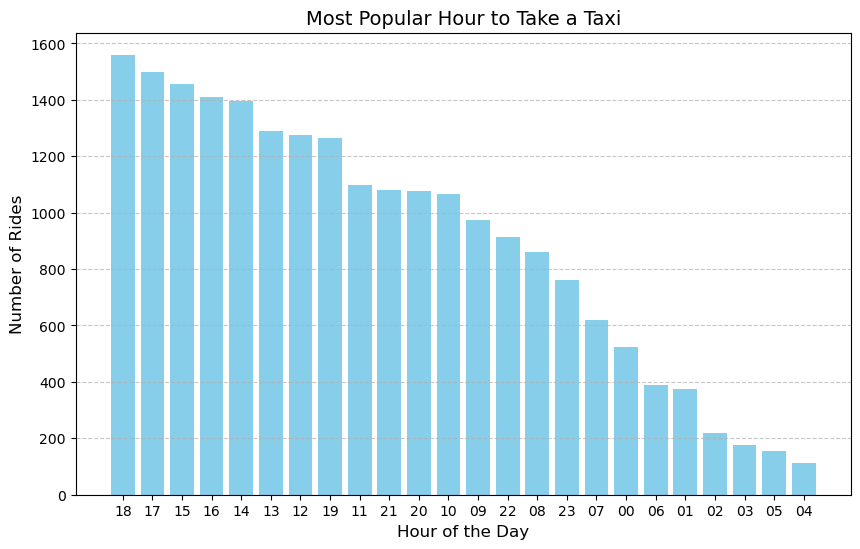

In [63]:
some_dataframe = get_data_for_visual_1()
plot_visual_1(some_dataframe)

### Visulization 2

In [64]:
def get_data_for_visual_2():
    query = """
    SELECT 
        strftime('%m', pickup_datetime) AS month,
        AVG(trip_distance) AS avg_distance,
        COUNT(*) AS total_trips
    FROM (
        SELECT 
            tpep_pickup_datetime AS pickup_datetime, 
            trip_distance 
        FROM taxi_trips
        WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
        UNION ALL
        SELECT 
            pickup_datetime, 
            trip_miles AS trip_distance 
        FROM uber_trips
        WHERE pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    )
    GROUP BY month
    ORDER BY month;
    """
    return pd.read_sql(query, con=engine)

In [65]:
def plot_visual_2_with_matplotlib(dataframe):
    dataframe['month'] = dataframe['month'].astype(int)
    dataframe = dataframe.sort_values(by='month')
    
    avg_distances = dataframe['avg_distance']
    sample_size = dataframe['total_trips']
    std_error = avg_distances.std() / (sample_size ** 0.5)  # Standard Error
    confidence = 0.90
    errors = t.ppf((1 + confidence) / 2, sample_size - 1) * std_error

    # Plot
    figure, ax = plt.subplots(figsize=(10, 6))
    ax.bar(dataframe['month'], avg_distances, yerr=errors, capsize=5, color='blue', alpha=0.7)
    ax.set_title("Average Distance Traveled per Month with 90% Confidence Interval", fontsize=14)
    ax.set_xlabel("Month", fontsize=12)
    ax.set_ylabel("Average Distance (Miles)", fontsize=12)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

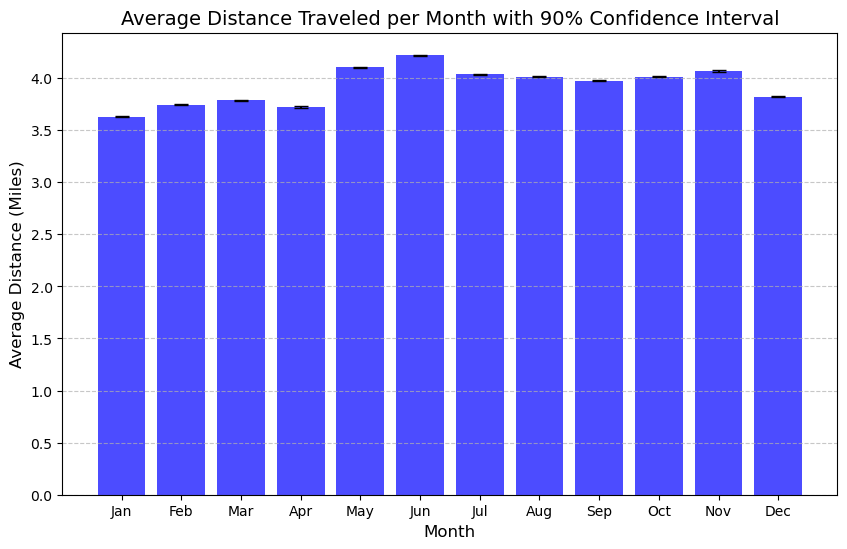

In [66]:
some_dataframe = get_data_for_visual_2()
plot_visual_2_with_matplotlib(some_dataframe)

### Visualization 3

In [67]:
def get_data_for_visual_3():
    query = """
    SELECT 
        strftime('%w', tpep_dropoff_datetime) AS day_of_week,
        COUNT(*) AS total_rides,
        CASE
            WHEN DOLocationID IN (1, 2, 3) THEN 'LGA'
            WHEN DOLocationID IN (4, 5, 6) THEN 'JFK'
            WHEN DOLocationID IN (7, 8, 9) THEN 'EWR'
            ELSE NULL
        END AS airport
    FROM taxi_trips
    WHERE tpep_dropoff_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY day_of_week, airport;
    """
    return pd.read_sql(query, con=engine)

In [68]:
def plot_visual_3(dataframe):
    # Convert day_of_week to readable format
    day_map = {
        '0': 'Sunday', '1': 'Monday', '2': 'Tuesday',
        '3': 'Wednesday', '4': 'Thursday', '5': 'Friday', '6': 'Saturday'
    }
    dataframe['day_of_week'] = dataframe['day_of_week'].astype(str).map(day_map)
    
    # Create the plot
    figure, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(
        data=dataframe,
        x='day_of_week', y='total_rides', hue='airport', ax=ax
    )
    ax.set_title("Most Popular Day for Airport Rides", fontsize=14)
    ax.set_xlabel("Day of the Week", fontsize=12)
    ax.set_ylabel("Number of Rides", fontsize=12)
    ax.legend(title="Airport")
    plt.show()

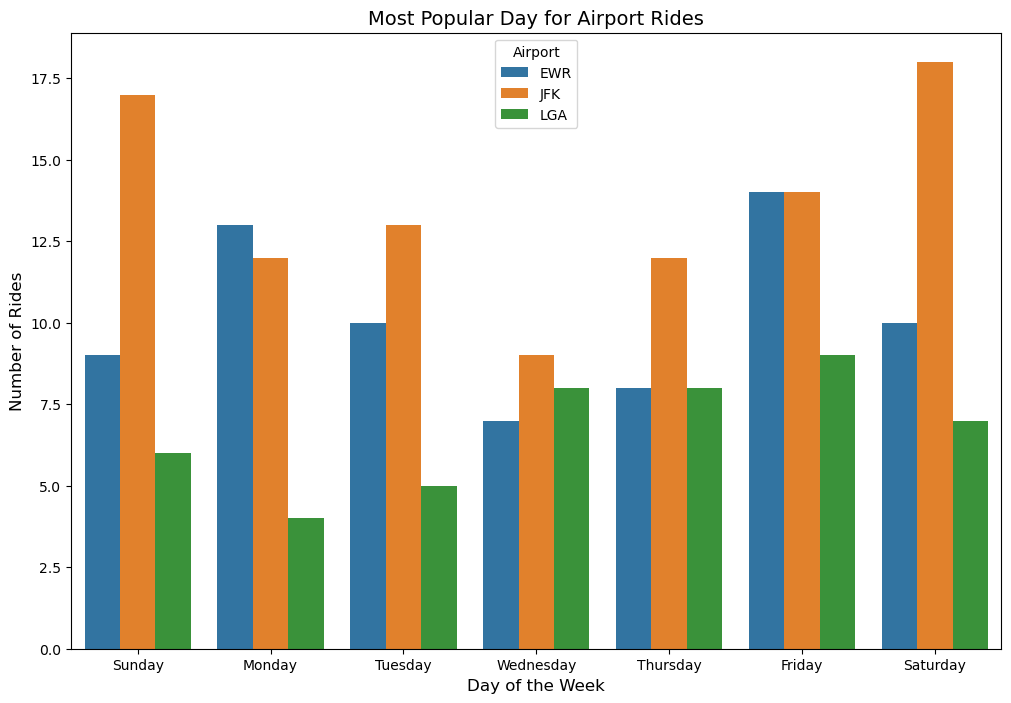

In [69]:
some_dataframe = get_data_for_visual_3()
plot_visual_3(some_dataframe)

### Visualization 4

In [70]:
def get_data_for_visual_4():
    query = """
    SELECT 
        strftime('%Y-%m', tpep_pickup_datetime) AS month,
        'Taxi' AS service,
        SUM(fare_amount + extra + mta_tax + tolls_amount + improvement_surcharge + congestion_surcharge) AS total_fare,
        SUM(fare_amount) AS base_fare,
        SUM(extra + improvement_surcharge + congestion_surcharge) AS surcharges,
        SUM(mta_tax) AS taxes,
        SUM(tolls_amount) AS tolls
    FROM taxi_trips
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY month
    
    UNION ALL
    
    SELECT 
        strftime('%Y-%m', request_datetime) AS month,
        'Uber' AS service,
        SUM(base_passenger_fare + tolls + bcf + sales_tax + congestion_surcharge + airport_fee) AS total_fare,
        SUM(base_passenger_fare) AS base_fare,
        SUM(bcf + congestion_surcharge + airport_fee) AS surcharges,
        SUM(sales_tax) AS taxes,
        SUM(tolls) AS tolls
    FROM uber_trips
    WHERE request_datetime BETWEEN '2020-01-01' AND '2024-08-31'
    GROUP BY month;
    """
    return pd.read_sql(query, con=engine)

In [71]:
def plot_visual_4(dataframe):
    # Convert 'month' to datetime format for proper sorting
    dataframe['month'] = pd.to_datetime(dataframe['month'], format='%Y-%m')

    # Separate data by service
    taxi_data = dataframe[dataframe['service'] == 'Taxi']
    uber_data = dataframe[dataframe['service'] == 'Uber']

    # Plot stacked bars
    figure, ax = plt.subplots(figsize=(14, 8))

    # Taxi fares
    ax.bar(taxi_data['month'], taxi_data['base_fare'], label='Taxi: Base Fare', width=20, align='center')
    ax.bar(taxi_data['month'], taxi_data['surcharges'], bottom=taxi_data['base_fare'], label='Taxi: Surcharges', width=20)
    ax.bar(taxi_data['month'], taxi_data['taxes'], bottom=taxi_data['base_fare'] + taxi_data['surcharges'], label='Taxi: Taxes', width=20)
    ax.bar(taxi_data['month'], taxi_data['tolls'], bottom=taxi_data['base_fare'] + taxi_data['surcharges'] + taxi_data['taxes'], label='Taxi: Tolls', width=20)

    # Uber fares
    ax.bar(uber_data['month'], uber_data['base_fare'], label='Uber: Base Fare', width=20, align='edge')
    ax.bar(uber_data['month'], uber_data['surcharges'], bottom=uber_data['base_fare'], label='Uber: Surcharges', width=20, align='edge')
    ax.bar(uber_data['month'], uber_data['taxes'], bottom=uber_data['base_fare'] + uber_data['surcharges'], label='Uber: Taxes', width=20, align='edge')
    ax.bar(uber_data['month'], uber_data['tolls'], bottom=uber_data['base_fare'] + uber_data['surcharges'] + uber_data['taxes'], label='Uber: Tolls', width=20, align='edge')

    # Set labels, title, and legend
    ax.set_title("Monthly Earned Total Fares by Service (January 2020 - August 2024)", fontsize=16)
    ax.set_xlabel("Month", fontsize=14)
    ax.set_ylabel("Total Fare ($)", fontsize=14)
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Fare Breakdown")
    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.show()

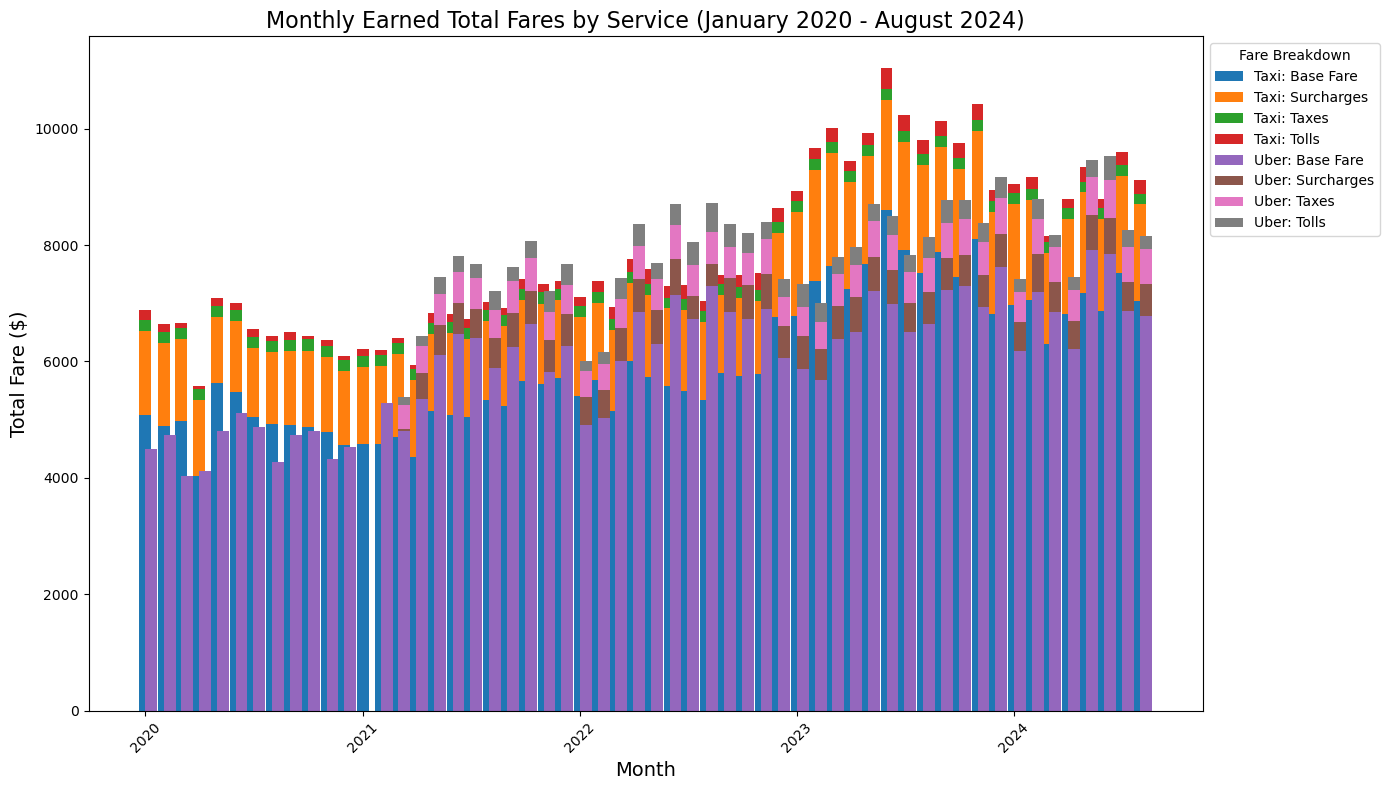

In [72]:
some_dataframe = get_data_for_visual_4()
plot_visual_4(some_dataframe)

### Visualization 5

In [73]:
def get_data_for_visual_5():
    query = """
    SELECT 
        trip_distance AS trip_distance, 
        tip_amount AS tip_amount, 
        DailyPrecipitation AS precipitation, 
        'Taxi' AS ride_type
    FROM 
        taxi_trips
    JOIN 
        daily_weather ON DATE(tpep_pickup_datetime) = daily_weather.DATE
    WHERE 
        tpep_pickup_datetime BETWEEN '2022-01-01' AND '2023-12-31'
    UNION ALL
    SELECT 
        trip_miles AS trip_distance, 
        tips AS tip_amount, 
        DailyPrecipitation AS precipitation, 
        'Uber' AS ride_type
    FROM 
        uber_trips
    JOIN 
        daily_weather ON DATE(pickup_datetime) = daily_weather.DATE
    WHERE 
        pickup_datetime BETWEEN '2022-01-01' AND '2023-12-31';
    """
    return pd.read_sql(query, con=engine)


In [74]:
def plot_visual_5(dataframe):
    taxi_data = dataframe[dataframe['ride_type'] == 'Taxi']
    uber_data = dataframe[dataframe['ride_type'] == 'Uber']

    figure, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Taxi: Distance vs Tip
    axes[0, 0].scatter(taxi_data['trip_distance'], taxi_data['tip_amount'], alpha=0.5, color='blue')
    axes[0, 0].set_title("Taxi: Distance vs Tip")
    axes[0, 0].set_xlabel("Trip Distance")
    axes[0, 0].set_ylabel("Tip Amount")

    # Uber: Distance vs Tip
    axes[0, 1].scatter(uber_data['trip_distance'], uber_data['tip_amount'], alpha=0.5, color='green')
    axes[0, 1].set_title("Uber: Distance vs Tip")
    axes[0, 1].set_xlabel("Trip Distance")
    axes[0, 1].set_ylabel("Tip Amount")

    # Taxi: Precipitation vs Tip
    axes[1, 0].scatter(taxi_data['precipitation'], taxi_data['tip_amount'], alpha=0.5, color='purple')
    axes[1, 0].set_title("Taxi: Precipitation vs Tip")
    axes[1, 0].set_xlabel("Precipitation")
    axes[1, 0].set_ylabel("Tip Amount")

    # Uber: Precipitation vs Tip
    axes[1, 1].scatter(uber_data['precipitation'], uber_data['tip_amount'], alpha=0.5, color='orange')
    axes[1, 1].set_title("Uber: Precipitation vs Tip")
    axes[1, 1].set_xlabel("Precipitation")
    axes[1, 1].set_ylabel("Tip Amount")

    plt.tight_layout()
    plt.show()

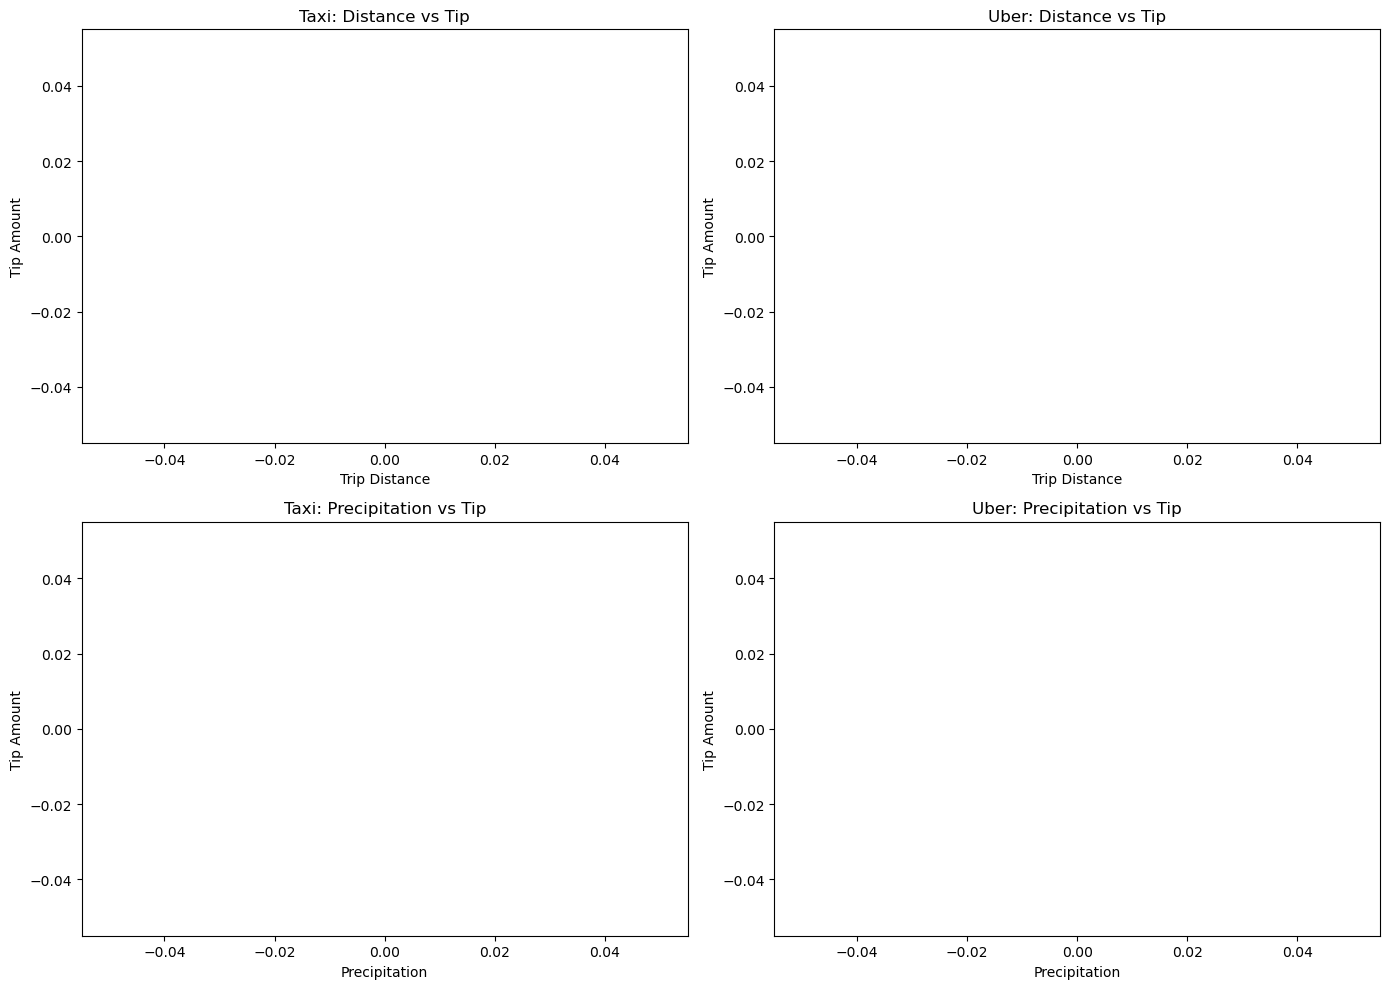

In [75]:
some_dataframe = get_data_for_visual_5()
plot_visual_5(some_dataframe)

In [76]:
query = """
SELECT COUNT(*)
FROM taxi_trips
JOIN daily_weather ON DATE(tpep_pickup_datetime) = daily_weather.DATE
WHERE tpep_pickup_datetime BETWEEN '2022-01-01' AND '2023-12-31';
"""
result = pd.read_sql(query, con=engine)
print(result)

   COUNT(*)
0         0


### Visualization 6

In [78]:
from sqlalchemy import create_engine

# create database
engine = create_engine("sqlite:///project.db")

# checking tables in database
with engine.connect() as connection:
    result = connection.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [row[0] for row in result]
    print("tables_in_db:", tables)

# checking struture
for table in tables:
    print(f"\n table {table}'s tructure:")
    with engine.connect() as connection:
        result = connection.execute(f"PRAGMA table_info({table});")
        for row in result:
            print(row)


ObjectNotExecutableError: Not an executable object: "SELECT name FROM sqlite_master WHERE type='table';"

In [ ]:
def get_data_for_visual_6():
    query = """
    SELECT
        location_lookup.longitude AS lon,
        location_lookup.latitude AS lat
    FROM taxi_trips
    JOIN location_lookup
    ON taxi_trips.PULocationID = location_lookup.location_id
    WHERE tpep_pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31'
    UNION ALL
    SELECT
        location_lookup.longitude AS lon,
        location_lookup.latitude AS lat
    FROM uber_trips
    JOIN location_lookup
    ON uber_trips.PULocationID = location_lookup.location_id
    WHERE pickup_datetime BETWEEN '2020-01-01' AND '2020-12-31';
    """
    try:
        dataframe = pd.read_sql(query, con=engine)
        print(f"Data loaded successfully! Rows fetched: {len(dataframe)}")
        return dataframe
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None

In [ ]:
def plot_visual_6(dataframe):
    if dataframe is None or dataframe.empty:
        print("No data to plot.")
        return

    heat_data = dataframe[['lat', 'lon']].dropna()

    if heat_data.empty:
        print("No valid coordinates found.")
        return

    base_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)
    HeatMap(data=heat_data.values.tolist(), radius=8).add_to(base_map)
    base_map.save("heatmap_2020.html")
    print("Heatmap saved as 'heatmap_2020.html'.")

In [ ]:
some_dataframe = get_data_for_visual_6()
plot_visual_6(some_dataframe)